In [18]:
# This note book is a copy from https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic 
#   with learning purposes

# imports
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                #statistical data visualization
sns.set_style('whitegrid')           #changing styles of plots
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC               #C-Support Vector Classification and Linear Support Vector Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB           #perform online updates to model parameters via partial_fit method

In [19]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
titanic_df.info()
print("-----------------------------------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket        

In [21]:
# dropping unnecessary columns
# this columns will not help the prediction
# /* PassengerId, Name, Ticket */
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
# we don't drop 'PassengerId' in test dataset 
# because we need it to create the submission file
test_df = test_df.drop(['Name', 'Ticket'], axis=1)

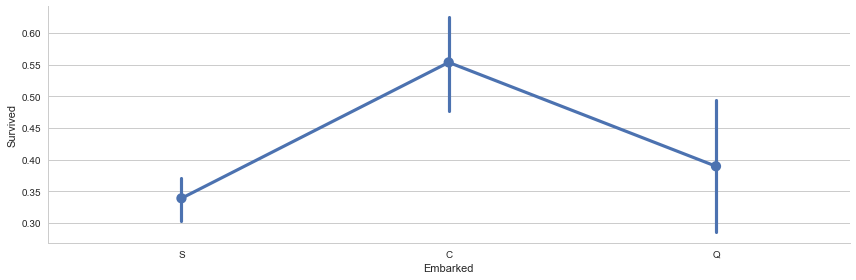

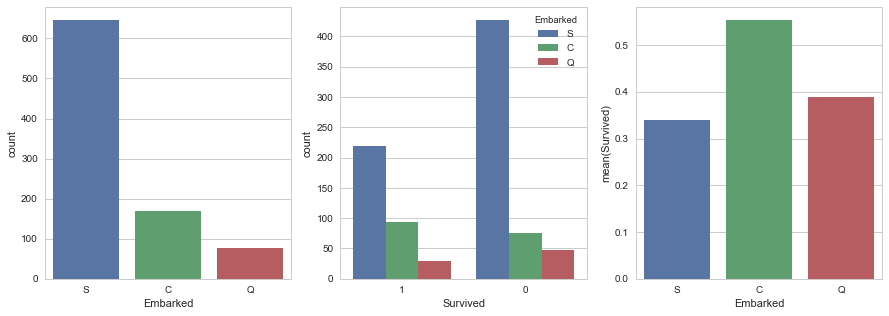

In [22]:
# let's now format the 'Embarked' feature
# there are some missing values so, we will fill them 
# with the most common value, which is 'S'
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')

# plotting the relationship between Embarked_Place and Survived
# we want to see if Embarked place influences the fact if a person survived or not
sns.factorplot('Embarked', 'Survived', data=titanic_df, size=4, aspect=3)      #facet_width = (size*aspect) inches

# creating 3 plots about the relationship
fig, (axis1,axis2,axis3) = plt.subplots(1, 3, figsize=(15,5)) 
# count how many samples embarked for every embark_place
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
# count how many samples survived for every embark_place
sns.countplot(x='Survived', hue='Embarked', data=titanic_df, order=[1,0], ax=axis2)
# group by embark, and get the mean of survived samples for every embark_place 
embark_perc = titanic_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc, order=['S', 'C', 'Q'], ax=axis3)

In [23]:
# either to consider Embarked feature in predictions we note 
# that C and Q categories have a bigger influence on survived
# feature, so we decide to remove S dummy variable 

# Note! that we could alse drop Embarked feature, beacause
# we could say that where a person embarked shouldn't influence 
# the fact that a person survived or not

# for training_set
embarked_dummies_titanic = pd.get_dummies(titanic_df['Embarked'])  # Transform cathegory in continous
embarked_dummies_titanic.drop(['S'], axis=1, inplace=True)       # If inplace=True, do operation inplace and return None

# for test set
embarked_dummies_test = pd.get_dummies(test_df['Embarked'])
embarked_dummies_test.drop(['S'], axis=1, inplace=True)

# modify original sets
titanic_df = titanic_df.join(embarked_dummies_titanic)
test_df = test_df.join(embarked_dummies_test)

# drop Embarked feature because we have already continouzed it
titanic_df.drop(['Embarked'], axis=1, inplace=True)
test_df.drop(['Embarked'], axis=1, inplace=True)

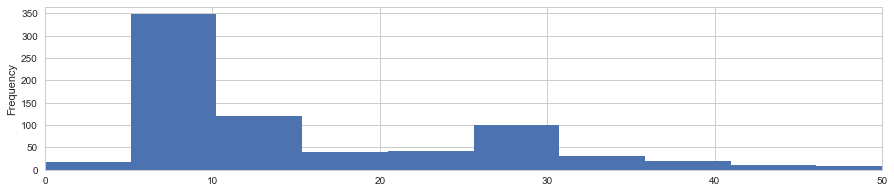

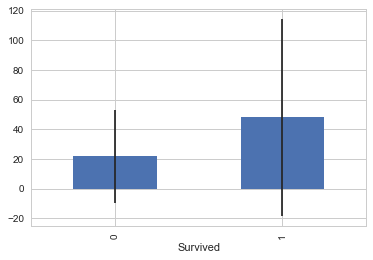

In [24]:
# formatting Fare feature

# we found a missing value in test_df['Fare'] so we have to fill it
# we choose to fill it with the median value
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

#convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and standard_deviaton (std) for fare of survived and not_survived passengers
average_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plotting an histogram distribution of Fare feature values
titanic_df['Fare'].plot(kind='hist', figsize=(15, 3), bins=100, xlim=(0,50))

average_fare.index.names = std_fare.index.names = ['Survived']
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

C:\Users\Guillermo\Anaconda3\envs\EJE1\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Guillermo\Anaconda3\envs\EJE1\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


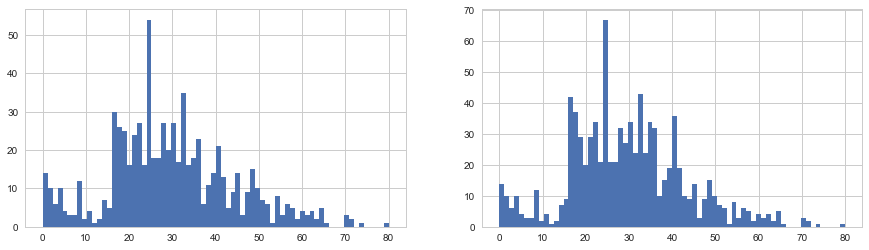

In [25]:
# Age

# create 2 sublots
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: remember to drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)

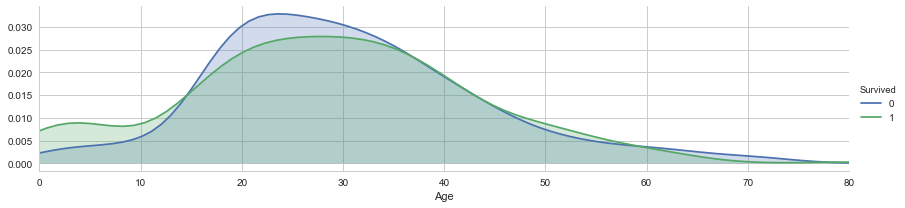

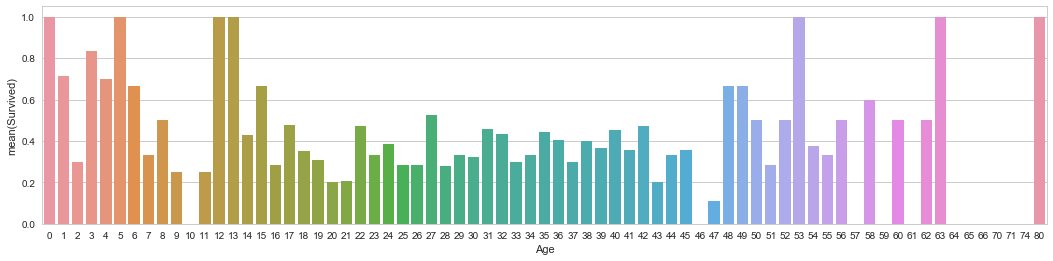

In [26]:
# we continue to plot Age column to understand more about relashionship with survived

# let's plot the peaks ages for survived and not_survived passengers
facet = sns.FacetGrid(titanic_df, hue="Survived", aspect=4) # FacetGrid draws plots with multiple Axes
facet.map(sns.kdeplot, 'Age', shade=True) 
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# let's plot the average of survived passengers by Age
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
average_age = titanic_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [27]:
# Cabin

# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

In [28]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int32
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int32
C           891 non-null uint8
Q           891 non-null uint8
dtypes: int32(2), int64(4), object(1), uint8(2)
memory usage: 43.6+ KB


C:\Users\Guillermo\Anaconda3\envs\EJE1\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


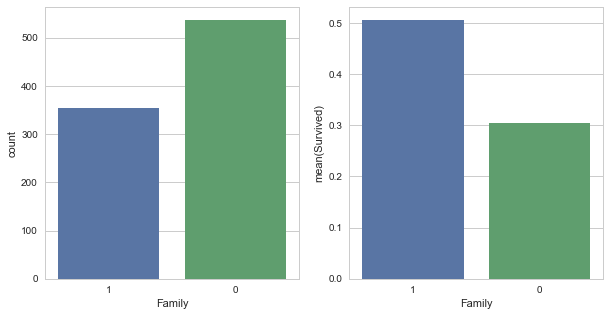

In [29]:
# Family

# Instead of havo two features Parch & SibSp
# We can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not
titanic_df['Family'] = titanic_df['Parch'] + titanic_df['SibSp']
# DataFrame.loc = Purely label-location based indexer for selection by label
titanic_df['Family'].loc[titanic_df['Family']>0] = 1
titanic_df['Family'].loc[titanic_df['Family']==0] = 0

test_df['Family'] = test_df['Parch'] + test_df['SibSp']
test_df['Family'].loc[test_df['Family']>0] = 1
test_df['Family'].loc[test_df['Family']==0] = 0



# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

# plot the relationship between Family and Survived
fig, (axis1,axis2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))

# plotting how many samples have or not have familiars on board
sns.countplot(x='Family', data=titanic_df, order=(1,0), ax=axis1)

# compute the average of survived for those who have and don't have family on board
family_perc = titanic_df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

# plot a bargraph with the averages
sns.barplot(x='Family', y='Survived', data=family_perc, order=(1,0), ax=axis2)

#titanic_df = titanic_df.drop(['SibSp', 'Parch'])

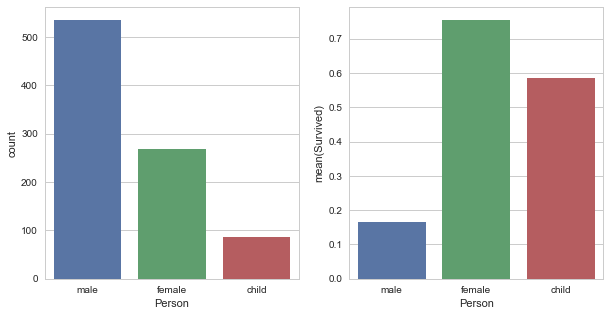

In [30]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

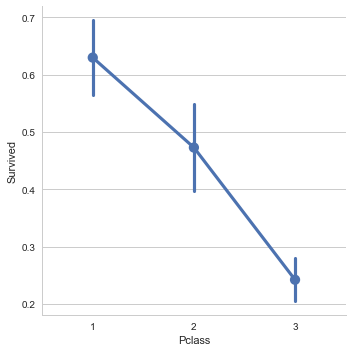

In [31]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [32]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [33]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred_Best = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.96857463524130194

In [34]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_Best
    })
submission.to_csv('titanic.csv', index=False)